In [28]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import exhaustive_search
from dmba import adjusted_r2_score, AIC_score, BIC_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [66]:
df = pd.read_csv("D600Task2Dataset1HousingInformation.csv")
df.head()

,ID,Price,SquareFootage,NumBathrooms,NumBedrooms,BackyardSpace,CrimeRate,SchoolRating,AgeOfHome,DistanceToCityCenter,...,RenovationQuality,LocalAmenities,TransportAccess,Fireplace,HouseColor,Garage,Floors,Windows,PreviousSalePrice,IsLuxury
0,4922,255614.8992,566.62,1.000000,4,779.42,20.56,5.62,39.46,10.08,...,4.93,4.44,4.55,Yes,Blue,No,1,13,181861.54230,0
1,5009,155586.0947,1472.34,1.000000,2,656.13,15.62,5.63,40.51,7.89,...,4.08,5.56,6.83,No,Green,No,1,17,50042.59757,0
2,4450,131050.8324,550.00,1.779354,3,754.57,12.47,9.20,48.38,23.74,...,4.26,8.07,8.48,Yes,Green,Yes,2,34,48400.34440,0
3,1070,151361.7125,941.81,2.035254,2,439.59,22.22,7.08,94.67,5.22,...,4.45,5.00,6.27,Yes,Red,No,1,14,84594.12145,0
4,400,113167.6128,550.00,1.064644,3,353.03,8.28,5.93,16.80,43.13,...,3.36,5.46,6.99,No,White,Yes,1,21,22934.59654,0


In [30]:
df[['CrimeRate', 'SchoolRating', 'LocalAmenities', 'IsLuxury']].describe()

,CrimeRate,SchoolRating,LocalAmenities,IsLuxury
count,7000.000000,7000.000000,7000.000000,7000.00000
mean,31.226194,6.942923,5.934579,0.50400
std,18.025327,1.888148,2.657930,0.50002
min,0.030000,0.220000,0.000000,0.00000
25%,17.390000,5.650000,4.000000,0.00000
50%,30.385000,7.010000,6.040000,1.00000
75%,43.670000,8.360000,8.050000,1.00000
max,99.730000,10.000000,10.000000,1.00000


In [31]:
# Identifying Predictors For Model

Predictors = ['CrimeRate', 'SchoolRating',
              'LocalAmenities']
outcome = 'IsLuxury'

# Partitioning Data

X = pd.get_dummies(df[Predictors], drop_first=True)
y=df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

df_lr = LogisticRegression()
df_lr.fit(train_X, train_y)

# Printing Coefficients from Training Set
print(pd.DataFrame({'Predictor': X.columns, 'Coefficient': df_lr.coef_.flatten()}))

# Showcasing Performance Measures (for training)
print(classificationSummary(train_y, df_lr.predict(train_X)))

        Predictor  Coefficient
0       CrimeRate     0.001914
1    SchoolRating     0.301436
2  LocalAmenities     0.078373
Confusion Matrix (Accuracy 0.6224)

       Prediction
Actual    0    1
     0 1249  834
     1  752 1365
None


In [32]:
def train_model(variables):
    model = LogisticRegression()
    model.fit(train_X[list(variables)], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[list(variables)])
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = list(result['variables'])
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables)))

# Because AIC is lowest where N=3, I think the optimized model should be the one
#with all the original variables.

,n,r2adj,AIC,CrimeRate,LocalAmenities,SchoolRating
0,1,0.539515,7913.535305,False,False,True
1,2,0.514746,7845.411541,False,True,True
2,3,0.510935,7834.832190,True,True,True


In [33]:
#Train Performance
print(classificationSummary(train_y, df_lr.predict(train_X)))

Confusion Matrix (Accuracy 0.6224)

       Prediction
Actual    0    1
     0 1249  834
     1  752 1365
None


In [34]:
#Test Performance
print(classificationSummary(valid_y, df_lr.predict(valid_X)))

Confusion Matrix (Accuracy 0.6114)

       Prediction
Actual   0   1
     0 832 557
     1 531 880
None


In [35]:
#Train Model

#Combine the filtered predictors with train_y
train_df = train_X.join(train_y)

# Create the formula for logistic regression
formula = 'IsLuxury ~ ' + ' + '.join(Predictors)

# Fit the logistic regression model
housetrain_logit = sm.Logit.from_formula(formula, data=train_df).fit()

# Display the summary of the model
print(housetrain_logit.summary())

Optimization terminated successfully.
         Current function value: 0.650048
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               IsLuxury   No. Observations:                 4200
Model:                          Logit   Df Residuals:                     4196
Method:                           MLE   Df Model:                            3
Date:                Sun, 22 Dec 2024   Pseudo R-squ.:                 0.06213
Time:                        11:53:23   Log-Likelihood:                -2730.2
converged:                       True   LL-Null:                       -2911.1
Covariance Type:            nonrobust   LLR p-value:                 4.251e-78
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.6062      0.169    -15.465      0.000      -2.936      -2.276
CrimeRate        

In [36]:
#Test Model

#Combine the filtered predictors with train_y
valid_df = valid_X.join(valid_y)

# Create the formula for logistic regression
formula = 'IsLuxury ~ ' + ' + '.join(Predictors)

# Fit the logistic regression model
housevalid_logit = sm.Logit.from_formula(formula, data=valid_df).fit()

# Display the summary of the model
print(housevalid_logit.summary())

Optimization terminated successfully.
         Current function value: 0.658439
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               IsLuxury   No. Observations:                 2800
Model:                          Logit   Df Residuals:                     2796
Method:                           MLE   Df Model:                            3
Date:                Sun, 22 Dec 2024   Pseudo R-squ.:                 0.05003
Time:                        11:53:23   Log-Likelihood:                -1843.6
converged:                       True   LL-Null:                       -1940.7
Covariance Type:            nonrobust   LLR p-value:                 7.590e-42
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.2622      0.197    -11.460      0.000      -2.649      -1.875
CrimeRate        

In [37]:
# IsLuxury Binary
print(df['IsLuxury'].unique())


[0 1]


In [38]:
duplicates = df.duplicated()
print(df[duplicates])

Empty DataFrame
Columns: [ID, Price, SquareFootage, NumBathrooms, NumBedrooms, BackyardSpace, CrimeRate, SchoolRating, AgeOfHome, DistanceToCityCenter, EmploymentRate, PropertyTaxRate, RenovationQuality, LocalAmenities, TransportAccess, Fireplace, HouseColor, Garage, Floors, Windows, PreviousSalePrice, IsLuxury]
Index: []

[0 rows x 22 columns]


In [39]:
# Multicollinearity
predictors_df = train_X  # Assuming train_X_filtered contains only the predictors

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Predictor'] = predictors_df.columns
vif_data['VIF'] = [variance_inflation_factor(predictors_df.values, i) for i in range(predictors_df.shape[1])]

# Display the VIF values
print(vif_data)

        Predictor       VIF
0       CrimeRate  3.041785
1    SchoolRating  6.091481
2  LocalAmenities  5.366036


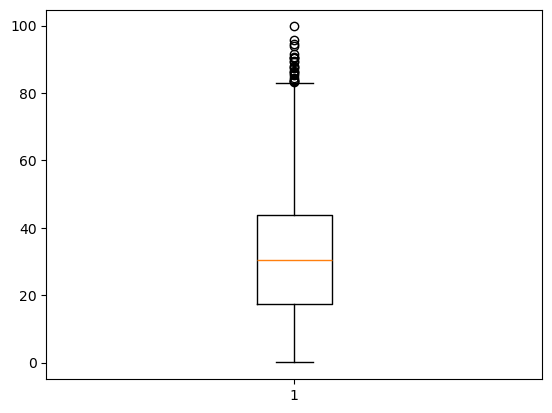

In [42]:
# Boxplot CrimeRate
data=df['CrimeRate']
plt.boxplot(data)
plt.show()


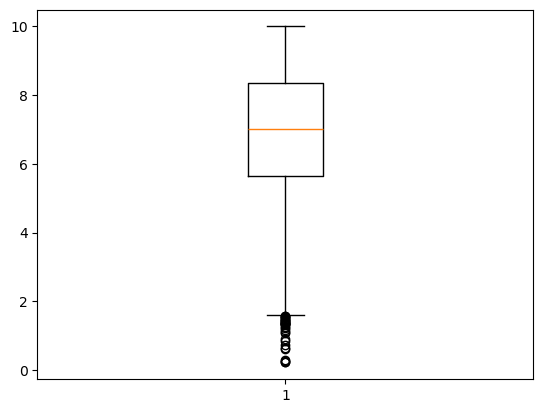

In [44]:
# Boxplot SchoolRating
data=df['SchoolRating']
plt.boxplot(data)
plt.show()

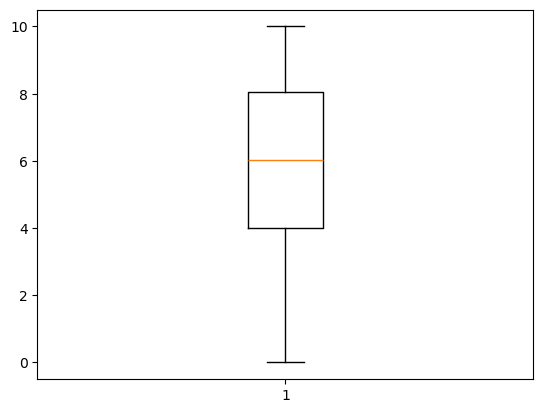

In [46]:
# Boxplot LocalAmenities 
data=df['LocalAmenities']
plt.boxplot(data)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

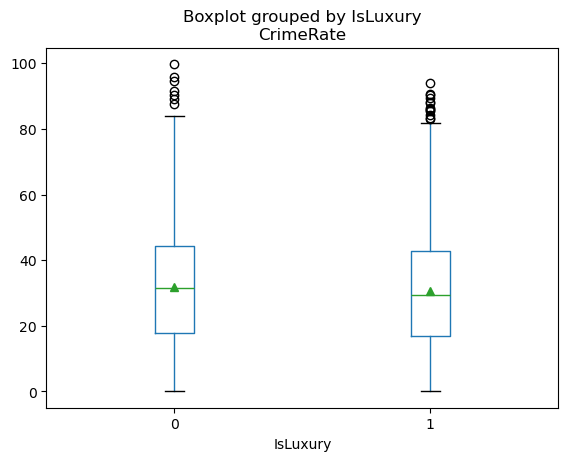

In [50]:
#CrimeRate Comparison
df.boxplot(column='CrimeRate', by='IsLuxury', grid=False, showmeans=True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

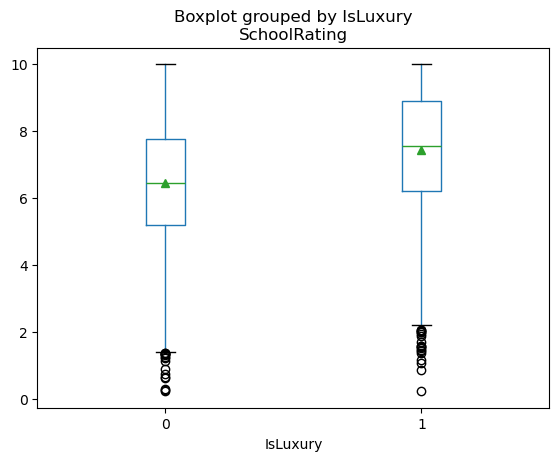

In [59]:
#SchoolRating Comparison
df.boxplot(column='SchoolRating', by='IsLuxury', grid=False, showmeans=True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

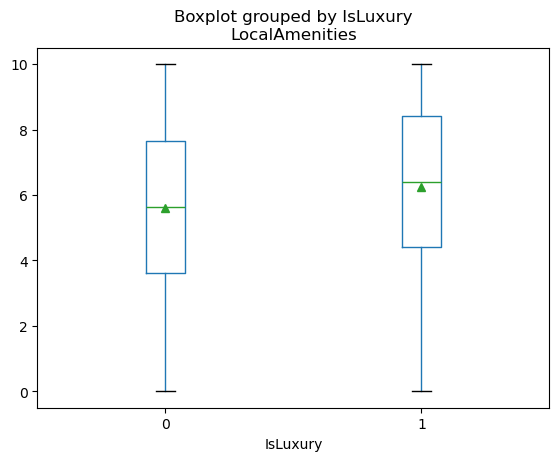

In [61]:
#LocalAmenities Comparison
df.boxplot(column='LocalAmenities', by='IsLuxury', grid=False, showmeans=True)
plt.show

In [63]:
# Printing out 

valid_df.to_csv('logistictest.csv')
train_df.to_csv('logistictrain.csv')